# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 ноября 2017, 23:59   
**Штраф за опоздание:** -2 балла после 23:59  4 декабря, -4 балла после 23:59 11 декабря, -6 баллов после 23:59 18 декабря

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Разбаловка:**   
За задание можно получить 10 баллов. Для этого нужно следующее:
1. Там, где написано "Ваш код", нужно реализовать метод или часть метода
2. Там, где написано "Что делает этот блок кода?", нужно разобраться в блоке кода и в комментарии написать, что он делает    
3. Добиться, чтобы в пункте "Проверка скорости работы" Ваша реализация работала чуть быстрее, чем у дерева из sklearn
4. Добиться, чтобы в пункте "Проверка качества работы" Ваша реализация работала качественнее, чем у дерева из sklearn

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [49]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print 'invalid criterion name'
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print 'invalid max_features name'
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - (np.sum(l_c**2 / l_s + r_c**2 / r_s, axis=1)).reshape(-1,1) / (l_s + r_s)
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        return -np.sum(l_c * np.log1p(l_c / l_s) + r_c * np.log1p(r_c / r_s),axis=1).reshape(-1,1) / (l_s + r_s)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - (np.max(l_c, axis=1).reshape(-1,1) + np.max(r_c, axis=1).reshape(-1,1)) / (l_s + r_s)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(sqrt(n_feature))] 
        
    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(log2(n_feature))] 

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        
        # Что делает этот блок кода?
        # Суть функции в целом - найти гиперплоскоть, с помощью которой можно
        # разделить выборку на два подмножества > или < threshhold
        # Сортировка х и у по возрастанию         
        sorted_x, sorted_y = self.__sort_samples(x, y)
        # Всего классов в выборке
        class_number = np.unique(y).shape[0]
        
        # Что делает этот блок кода?
        # min_samples_split - минимальное число объектов, требуемое, чтобы
        # разделить множество в узле дерева, поэтому отсекаем те объекты,
        # которые точно не будут удовлетворять min_samples_split
        splitted_sorted_y = sorted_y[self.min_samples_split:-self.min_samples_split]
        # r_border - "правые" индексы границы множеств объектов одного класса
        # т.е позиции, в которых меняются классы
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (self.min_samples_split + 1)
        
        if len(r_border_ids) == 0:
            return float('+inf'), None
        
        # Что делает этот блок кода?
        # eq_el_count - получаем размеры классов (количество элементов одного класса)
        eq_el_count = r_border_ids - np.append([self.min_samples_split], r_border_ids[:-1])
        # делаем кодировку границ в one-hot
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        # np.arange(r_border_ids.shape[0]) - этот индекс отвечает за позицию границы класса
        # в r_border_ids, sorted_y[r_border_ids - 1] - за номер класса
        # и записываем туда 1
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1
        # Получаем матрицу, строки - номер из r_border, столбцы - номер класса
        # В итоге в ячейках будут находиться количество элементов класса (в соответствующем столбце)
        # которые должны перейти из левого класса в правый при увеличении threshold
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(sorted_y[:self.min_samples_split], minlength=class_number)
        
        # Что делает этот блок кода?
        # Получаем количество элементов в левом и правом классе после разбиения
        l_class_count = np.cumsum(class_increments, axis=0)  
        # правый класс = Все - левый
        r_class_count = np.bincount(y) - l_class_count
        # количество элементов в левом классе дерева для каждого разбиения
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        # в правом
        r_sizes = sorted_y.shape[0] - l_sizes

        # Что делает этот блок кода?
        # находим impurity для всех разбиений в соответсттвии с тем, чему был равен
        # параметр criterion в конструкторе
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        # получаем индекс разбиения с минимальным impurity
        idx = np.argmin(gs)
    
        # Что делает этот блок кода?
        # получаем индекс последнего (крайнего) элемента, который удовлетиворяет
        # выбранному разбиению
        left_el_id = l_sizes[idx][0]
        # возвращаем impurity и threshold
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0
          
    def add_leaf(self, y , node_id):
        class_counts = np.bincount(y, minlength=self.num_class) 
        class_probs = class_counts / np.sum(class_counts).astype('float')
        self.tree[node_id] = (self.LEAF_TYPE, np.argmax(class_counts), class_probs) #########
    
    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        # Ваш код
        # Необходимо использовать следующее:
        # self.LEAF_TYPE
        # self.NON_LEAF_TYPE

        # self.tree
        # self.max_depth
        # self.sufficient_share
        # self.min_samples_split

        # self.get_feature_ids
        # self.__find_threshold
        # self.__div_samples
        # self.__fit_node
        
        if depth == self.max_depth or x.shape[0] < self.min_samples_split or np.unique(y).shape[0] == 1:
            self.add_leaf(y, node_id)
            return              
        
        features_threshold = np.zeros(x.shape[1])
        features_impurity = np.zeros(x.shape[1])
        
        for feature_id in self.get_feature_ids(x.shape[1]):
            features_impurity[feature_id], features_threshold[feature_id] = self.__find_threshold(x[:,feature_id],y)
        
        best_feture_id = np.argmin(features_impurity)
        
        if np.isnan(features_threshold[best_feture_id]):
            self.add_leaf(y, node_id)
            return
        
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, best_feture_id, features_threshold[best_feture_id])
        
        if y_l.shape[0] == 0 or y_r.shape[0] == 0:
            self.add_leaf(y,node_id)
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE,best_feture_id,features_threshold[best_feture_id])
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)        
        
    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)


In [50]:
df = pd.read_csv('./cs-training.csv', sep=',').dropna()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [51]:
x = df.as_matrix(columns=df.columns[1:])
y = df.as_matrix(columns=df.columns[:1])
y = y.reshape(y.shape[0])

In [52]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2,criterion='gini')
clf = DecisionTreeClassifier(min_samples_split=2)

## Проверка скорости работы

In [53]:
t1 = time()
my_clf.fit(x, y)
t2 = time()
print(t2 - t1)

t1 = time()
clf.fit(x, y)
t2 = time()
print(t2 - t1)

0.40099978447
1.03100013733


## Проверка качества работы

In [54]:
gkf = KFold(n_splits=5, shuffle=True)

In [55]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    my_clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.933482996591
0.933566142845
0.931820071506
0.93335827721
0.930486841558


In [56]:
for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    clf.fit(X_train, y_train)
    print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

0.892284027605
0.893614367673
0.89394695269
0.892284027605
0.895563962915


# Измерение качества разбиения с помощью sklearn blobs

In [46]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1233)

idx = range(1000)
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

X_train = X[500:]
y_train = y[500:]

X_test = X[:500]
y_test = y[:500]

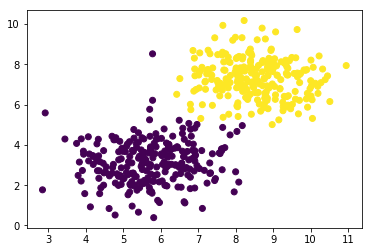

0.99


In [47]:
my_clf = MyDecisionTreeClassifier(criterion='misclass')
my_clf.fit(X_train, y_train)
y_pred = my_clf.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred)
plt.show()
print accuracy_score(y_test, y_pred)

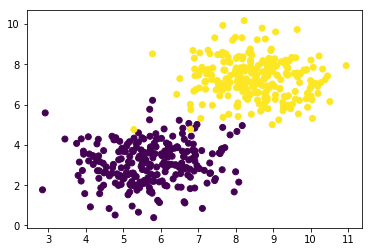

0.988


In [48]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred)
plt.show()
print accuracy_score(y_test, y_pred)